# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD4 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de :
- Choisir un modèle sur la base de l'estimation ou de la prédiction.
- Vérifier pour la présence de multicolinéarité.
- Transformer les variables pour modéliser des relations non-linéaires.


## Contexte : Poids des poissons

Le fichier *fishweights.csv* contient les caractéristiques de 158 poissons péchés dans le lac Laengelmavesi en Finlande. Nous étudierons le poids (Weight en grammes) des poissons en fonction de variables explicatives suivantes :
- l'espèce de poisson (species) ;
- la longueur standard (StandardLength) ;
- la longeur non standard  (NonStandardLength) ;
- la longueur totale (TotalLength) ;
- la hauteur (Height) ;
- la largeur (Width).


          ___/////___                  _
         /           \    ___          |
       /\             \_ /  /          H
     <   )            __)  \           |
       \/_\\_________/   \__\          _

     |------- SL -------|
     |------- NSL ---------|
     |------- TL ------------|

In [2]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
using Statistics

## Chargement des données

In [3]:
data = CSV.read("fishweights.csv", DataFrame)
first(data,10)

10×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Brème       242.0            23.2               25.4         30.0     1 ⋯
   2 │ Brème       290.0            24.0               26.3         31.2     1
   3 │ Brème       340.0            23.9               26.5         31.1     1
   4 │ Brème       363.0            26.3               29.0         33.5     1
   5 │ Brème       430.0            26.5               29.0         34.0     1 ⋯
   6 │ Brème       450.0            26.8               29.7         34.7     1
   7 │ Brème       500.0            26.8               29.7         34.5     1
   8 │ Brème       390.0            27.6               30.0         35.0     1
   9 │ Brème       450.0            27.6               30.0         35.1     1 ⋯
  10 │ Brème       500.0            28.5               30.7         36.2     1
                                                               2 columns omitted

# Exercice 1 - Analyse exploratoire

## a) Illustrez les poids en fonction des espèces de poisson

**Note :** Avec Gadfly, la variable *x* peut être une variable catégorielle.

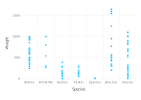

In [4]:
y=data[:,2] # Weight

x1=data[:,1] # Species
x2=data[:,3] # StandardLength
x3=data[:,4] # NonStandardLength
x4=data[:,5] # TotalLength
x5=data[:,6] # Height
x6=data[:,7] # Width

categories=["Brème","Whitefish","Gardon","Parkki","Éperlan","Brochet","Perche"]

plot(x=x1,y=y, Guide.xlabel("Species"),Guide.ylabel("Weight"), Coord.cartesian(ymin=0, ymax=1700))

## b) Illustrez les poids en fonction de la longeur standard et des espèces.

**Suggestion :** Utilisez l'option *color* de Gadfly pour distinguer les différentes espèces.

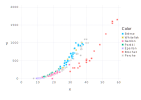

In [5]:
plot(data, x=x2, y=y, color=x1, Geom.point)

## c) Calculez le poids moyen pour chaque espèce ainsi que le nombre d'observations pour chaque espèce.

Les fonctions `combine()` et `groupby()` permettent d'effectuer rapidement ces tâches. Puisqu'elles ne sont pas intuitives, je vous donne d'emblée la réponse. C'est une combinaison de commandes qui pourra vous être utile dans tout le cours.

In [6]:
df = combine(groupby(data, :Species), :Weight => mean => :Weight, :Weight => length => :n)

7×3 DataFrame
 Row │ Species    Weight    n     
     │ String15   Float64   Int64 
─────┼────────────────────────────
   1 │ Brème      626.0        34
   2 │ Whitefish  531.0         6
   3 │ Gardon     152.05       20
   4 │ Parkki     154.818      11
   5 │ Éperlan     11.1786     14
   6 │ Brochet    718.706      17
   7 │ Perche     382.239      56

# Exercice 2 - Ajustement *vs* prédiction

Dans cet excercice, on considère le **poids** des éperlans en fonction de la **longueur standard**. On utilisera un ensemble d'entraînement ainsi qu'un ensemble de validation pour évaluer l'erreur de prédiction sur des données non utilisées pour l'estimation des paramètres.

In [7]:
"""
    construct_structure(x::Vector{<:Real}, order::Int)

Construction de la matrice de structure du modèle polynomial d'ordre `order` à partir du vecteur `x`.
"""
function construct_structure(x::Vector{<:Real}, order::Int)
    
    X = Array{Float64}(undef, length(x), order+1)
    
    for p in 0:order
       X[:,p+1] = x.^p 
    end
    
    return X
    
end

construct_structure

## a) Construction de l'ensemble d'entraînement et de validation pour les éperlans

In [8]:
eperlan = filter(row->row.Species=="Éperlan", data) # extracts rows with column Species value as Éperlan
train = eperlan[1:2:end, :]   # On récupère une ligne sur deux (1, 3, 5, etc.) pour l'ens. d'entraînement 
# 1:2 a l'air de dire commencer avec 1 et faire des bon de 2 jusqu'a la fin :end
validation = eperlan[2:2:end, :]; # On récupère une ligne sur deux (2, 4, 6, etc.) pour l'ens. de valid.
# 2:2 a l'air de dire commencer avec 2 et faire des bon de 2 jusqu'a la fin :end
println(eperlan)
println(train)
println(validation)


14×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Height   Width   
     │ String15  Float64  Float64         Float64            Float64      Float64  Float64 
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ Éperlan       6.7             9.3                9.8         10.8      1.7      1.0
   2 │ Éperlan       7.5            10.0               10.5         11.6      2.0      1.2
   3 │ Éperlan       7.0            10.1               10.6         11.6      1.7      1.1
   4 │ Éperlan       9.7            10.4               11.0         12.0      2.2      1.4
   5 │ Éperlan       9.8            10.7               11.2         12.4      2.1      1.3
   6 │ Éperlan       8.7            10.8               11.3         12.6      2.0      1.3
   7 │ Éperlan      10.0            11.3               11.8         13.1      2.2      1.3
   8 │ Éperlan       9.9            11.3               11.8         13.1

## b) Modèle linéaire

1. Estimez la droite de régression avec les données de l'ensemble d'entraînement.
2. Tracez la droite de régression ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `layer()` de Gadfly pour ajouter plusieurs couches à un graphique.

[6.7, 7.0, 9.8, 10.0, 9.8, 13.4, 19.7]


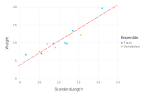

In [9]:
# estimation de l'hyperplan de regression
# Ajout d'une variable indicant à quelle ensemble appartient la donnée
eperlan[:, :Ensemble] .= "Train"
eperlan[2:2:end, :Ensemble] .= "Validation"

# construction de la matrice beta=inv(transpose(X)*X)*transpose(X)*y
ytrain=train.Weight # la colonne poid de l'ensemble d'entrainement
println(ytrain)
n=length(ytrain)

# on utilise la fonction en haut pour construire une matrice de structure 
# on donne l'ensemble pour entrainer avec l'ordre
# [1 x^1] sur chaque ligne de la colonne x
X2=construct_structure(train.StandardLength,1)

# B=inv(transpose(X)*X)*transpose(X)*y
#1
B=inv(X2'X2)X2'ytrain

#2
plot(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point,
    intercept = [B[1]], slope = [B[2]], Geom.abline(color="red", style=:dash))




## c) Modèle cubique

1. Estimez les paramètres du modèle cubique en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=3`.

[1.0 9.3 86.49000000000001 804.3570000000002; 1.0 10.1 102.00999999999999 1030.301; 1.0 10.7 114.48999999999998 1225.0429999999997; 1.0 11.3 127.69000000000001 1442.8970000000002; 1.0 11.4 129.96 1481.544; 1.0 11.7 136.89 1601.6129999999998; 1.0 13.2 174.23999999999998 2299.968]


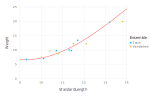

In [167]:
# 1 
# [1 x^1 x^2 x^3] chaque ligne de la colonne x
X2=construct_structure(train.StandardLength,3)

# estimation Beta
B= X2 \ train.Weight

#2 
# Définition du vecteur des x pour afficher le modèle
xx = collect(range(9, stop=14, length=20))  # collect() pour construire un vecteur à partir d'un range
# a partir de 9 jusqu'a 14 generer 20 nombre au hazard et les mettre dans le vecteur

# Construction de la matrice de structure associée au vecteur xx
XX = construct_structure(xx, 3)

# droite pour estimer les points aleatoires generes du vecteur
yy = XX*B

#  Affichage de la droite de régression 
# layer prend les x du vecteur et les y calculer par la droite yy, indique que c'est une ligne avec la couleur
model = layer(x = xx, y = yy, Geom.line, Theme(default_color=colorant"red"))

### Affichage des points :
# on va afficher tous les points du sous-ensemble (train et validation)
points = layer(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point)

set_default_plot_size(15cm, 10cm)
plot(points, model, Guide.yticks())

## d) Modèle d'ordre 6

1. Estimez les paramètres du modèle d'ordre 6 en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=6`.

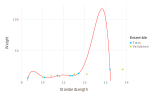

In [168]:
# 1 
# [1 x^1 x^2 x^3] chaque ligne de la colonne x
X2=construct_structure(train.StandardLength,6)

# estimation Beta
B= X2 \ train.Weight

#2 
# Définition du vecteur des x pour afficher le modèle
xx = collect(9:0.01:14)  # collect() pour construire un vecteur à partir d'un range
# a partir de 9 jusqu'a 14 generer on avance de 0.01

# Construction de la matrice de structure associée au vecteur xx
XX = construct_structure(xx, 6)

# droite pour estimer les points aleatoires generes du vecteur
yy = XX*B

#  Affichage de la droite de régression 
# layer prend les x du vecteur et les y calculer par la droite yy, indique que c'est une ligne avec la couleur
model = layer(x = xx, y = yy, Geom.line, Theme(default_color=colorant"red"))

### Affichage des points :
# on va afficher tous les points du sous-ensemble (train et validation)
points = layer(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point)

set_default_plot_size(15cm, 10cm)
plot(points, model, Coord.cartesian(ymin=5, ymax=120)) # set y min and max so that graph doesnt show negative y

## e) Calcul de la qualité d'ajustement et de l'erreur de prédiction

Pour les modèles d'ordre 0 à 6, calculez 
- le coefficient de détermination
- le coefficient de détermination ajusté
- l'erreur quadratique moyenne (MSE) sur l'échantillon de validation.

**Suggestion :** Ajoutez une ligne au tableau `df` proposé pour chacun des ordre de modèle avec la fonction `push!()`.


In [12]:
df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[]) # construction d'un tableau avec 4 colonne


# R2=SSR/SST 
function computeR2(y::Vector{<:Real},x::Vector{<:Real},ordre::Int)  # takes training set
    # calculer la variabilite total pour l'ensemble d'entrainement
    SST=sum((y[i]-mean(y))^2 for i=1:length(y))
    
    # matrice de structure
    X=construct_structure(x,ordre)
    B=X\y # trouve vecteur beta=inverse(transpose(X)*X)*transpose(X)*Y
    yslope=X*B # plan de regression estime
    
    # SSR=sum from 1 to n (yslope-ymean)^2
    SSR=sum((yslope[i]-mean(y))^2 for i=1:length(y))
    R2=SSR/SST
    return R2
end

R2ordre1=computeR2(train.Weight,train.StandardLength,1)
R2ordre2=computeR2(train.Weight,train.StandardLength,2)
R2ordre3=computeR2(train.Weight,train.StandardLength,3)
R2ordre4=computeR2(train.Weight,train.StandardLength,4)
R2ordre5=computeR2(train.Weight,train.StandardLength,5)
R2ordre6=computeR2(train.Weight,train.StandardLength,6)

R2=[R2ordre1 R2ordre2 R2ordre3 R2ordre4 R2ordre5 R2ordre6]

# R2ajuste=1-[(SSE/n-p-1)/(SST/(n-1))]
function computeR2aj(y::Vector{<:Real},x::Vector{<:Real},ordre::Int)  # takes training set
    # calculer la variabilite total pour l'ensemble d'entrainement
    SST=sum((y[i]-mean(y))^2 for i=1:length(y))
    
    # matrice de structure
    X=construct_structure(x,ordre)
    B=X\y # trouve vecteur beta=inverse(transpose(X)*X)*transpose(X)*Y
    yslope=X*B # plan de regression estime
    
    # SSE=sum from 1 to n (y-yslope)^2
    SSE=sum((y[i]-yslope[i])^2 for i=1:length(y))
    
    R2aj=1-((SSE/(length(y)-ordre-1))/(SST/(length(y)-1)))
    return R2aj
end  

R2ajordre1=computeR2aj(train.Weight,train.StandardLength,1)
R2ajordre2=computeR2aj(train.Weight,train.StandardLength,2)
R2ajordre3=computeR2aj(train.Weight,train.StandardLength,3)
R2ajordre4=computeR2aj(train.Weight,train.StandardLength,4)
R2ajordre5=computeR2aj(train.Weight,train.StandardLength,5)
R2ajordre6=computeR2aj(train.Weight,train.StandardLength,6)

R2aj=[R2ajordre1 R2ajordre2 R2ajordre3 R2ajordre4 R2ajordre5 R2ajordre6]

function computeBeta(y::Vector{<:Real},x::Vector{<:Real},ordre::Int)
   # matrice de structure
    X=construct_structure(x,ordre)
    B=X\y # trouve vecteur beta=inverse(transpose(X)*X)*transpose(X)*Y
    return B
end

# MSE=(1/nv)*sum from 1 to nv (%yslope-i%-y)^2
function computeMSE(yvalid::Vector{<:Real},xvalid::Vector{<:Real},B::Vector{<:Real},ordre::Int)  # takes training set
    Xvalid=construct_structure(xvalid,ordre)
    yslope=Xvalid*B  # pente en utilisant X de l'ensemble validation
    MSE=(1/length(yvalid))*sum((yvalid[i]-yslope[i])^2 for i=1:length(yvalid))
    return MSE
end    

B1=computeBeta(train.Weight,train.StandardLength,1)
MSEordre1=computeMSE(validation.Weight,validation.StandardLength,B1,1)

B2=computeBeta(train.Weight,train.StandardLength,2)
MSEordre2=computeMSE(validation.Weight,validation.StandardLength,B2,2)

B3=computeBeta(train.Weight,train.StandardLength,3)
MSEordre3=computeMSE(validation.Weight,validation.StandardLength,B3,3)

B4=computeBeta(train.Weight,train.StandardLength,4)
MSEordre4=computeMSE(validation.Weight,validation.StandardLength,B4,4)

B5=computeBeta(train.Weight,train.StandardLength,5)
MSEordre5=computeMSE(validation.Weight,validation.StandardLength,B5,5)

B6=computeBeta(train.Weight,train.StandardLength,6)
MSEordre6=computeMSE(validation.Weight,validation.StandardLength,B6,6)

MSE=[MSEordre1 MSEordre2 MSEordre3 MSEordre4 MSEordre5 MSEordre6]
  
ordre=[1 2 3 4 5 6]

println("R2=$R2")
println("R2aj=$R2aj")
println("MSE=$MSE")

R2=[0.8834932166926129 0.9609860435399318 0.9614746768165502 0.9627566727387082 0.9981742928067164 0.9999999921031872]
R2aj=[0.8601918600311353 0.9414790653098961 0.9229493536331228 0.8882700182194628 0.9890457580161516 -Inf]
MSE=[1.4396056224501603 3.0840829854884673 2.6606669884896212 1.7534082119750627 3008.557838286944 188439.59902928595]


## f) Sélection du meilleur modèle

Selon vous, quel est le meilleur modèle ?

In [13]:
# le meilleur modele selon l'estimation est le modele d'ordre 2 car R2j 2 ieme plus eleve 
# le meilleur modele selon la prediction est le modele d'ordre 1 car elle a la plus petite MSE

# Exercice 3 - Poids des perches

Dans cet exercice, on étudie la présence de multicolinéarité dans les variables explicatives pour les perches.

In [200]:
perche = filter(row -> row.Species == "Perche", data)
n = size(perche,1)
first(perche, 10)

56×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Height   Width   
     │ String15  Float64  Float64         Float64            Float64      Float64  Float64 
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ Perche        5.9             7.5                8.4          8.8      2.1      1.4
   2 │ Perche       32.0            12.5               13.7         14.7      3.5      2.0
   3 │ Perche       40.0            13.8               15.0         16.0      3.8      2.4
   4 │ Perche       51.5            15.0               16.2         17.2      4.6      2.6
   5 │ Perche       70.0            15.7               17.4         18.5      4.6      2.9
   6 │ Perche      100.0            16.2               18.0         19.2      5.2      3.3
   7 │ Perche       78.0            16.8               18.7         19.4      5.2      3.1
   8 │ Perche       80.0            17.2               19.0         20.2

## a) Détection de la multicolinéarité.

Calculez le facteur d'inflation de la variance VIF pour les variables explicatives de la perche. Déterminez s'il y a multicolinéarité.

In [199]:
# calculer le VIF de chaque var explicatif
# mettre chacun des variables explicatives en fonction des autres variables explicatives

function findvarcol(name::String,X::Any)
    colonneexc=0
    for i=1:length(names(X))
       if names(X)[i]==name
          colonneexc=i
       end
    end 
    return colonneexc
end

function cleanDataExcCol(x::Any,X::Any)
    return X[1:end,Not(names(x))]
end

function computeVIF(x::Any,X::Any)  
    # set dependent var x as y
    colName=names(x)[1]
    colnum=findvarcol(colName,X)
    X_idata=X[1:end,colnum:colnum]
    
    # build vector for target var
    X_i= hcat(Matrix(X_idata[:,1:1]))
    
    # exclude target dependent var from data
    data=cleanDataExcCol(X_idata,X)
    
    X = hcat(ones(n), Matrix(data[:,1:end])) # structure matrix
    
    # compute Beta=inverse(transpose(X)*X)*transpose(X)*Y
    B=inv(X'X)*(X'*X_i)

    x_i_slope=X*B
    
    # SSR=sum from 1 to n (yslope-ymean)^2 where both y are dependent variable
    SSR=sum((x_i_slope[i]-mean(X_i))^2 for i=1:length(X_i))
    
    # SST=sum from 1 to n (y-ymean)^2
    SST=sum((X_i[i]-mean(X_i))^2 for i=1:length(X_i))
    
    # Ri^2=SSR/SST
    Ri2=SSR/SST
    
    # VIF=1/(1-Ri^2)
    VIF=1/(1-Ri2)
    return VIF
end

weightcol=findvarcol("Weight",perche)
weight=perche[1:end,weightcol:weightcol] # colonne de weight
dependantvars=cleanDataExcCol(weight,perche) # donnees excluant la colonne weight

speciescol=findvarcol("Species",dependantvars)
species=dependantvars[1:end,speciescol:speciescol] # colonne de Species
numsdependantvars=cleanDataExcCol(species,dependantvars) # donnes excluant la colonne species

# compute VIF for StandardLength variable 
stdlengthcol=findvarcol("StandardLength",numsdependantvars)
stdlength=numsdependantvars[1:end,stdlengthcol:stdlengthcol]
VIFstdlength=computeVIF(stdlength,numsdependantvars)

# compute VIF for NonStandardLength variable 
nonstdlengthcol=findvarcol("NonStandardLength",numsdependantvars)
nonstdlength=numsdependantvars[1:end,nonstdlengthcol:nonstdlengthcol]
VIFnonstdlength=computeVIF(nonstdlength,numsdependantvars)

# compute VIF for TotalLength variable 
totallengthcol=findvarcol("TotalLength",numsdependantvars)
totallength=numsdependantvars[1:end,totallengthcol:totallengthcol]
VIFtotallength=computeVIF(totallength,numsdependantvars)

# compute VIF for Height variable 
heightcol=findvarcol("Height",numsdependantvars)
height=numsdependantvars[1:end,heightcol:heightcol]
VIFheight=computeVIF(height,numsdependantvars)

# compute VIF for Width variable 
widthcol=findvarcol("Width",numsdependantvars)
width=numsdependantvars[1:end,widthcol:widthcol]
VIFwidth=computeVIF(width,numsdependantvars)

VIF=[VIFstdlength; VIFnonstdlength; VIFtotallength; VIFheight; VIFwidth;]
# presence de multicolinearite entre toutes les variables VIF>10
# 1780.0127123018028
# 4629.381445146483
# 2381.0823801706647
#   55.17488780404191
#   31.378928138647893

5-element Vector{Float64}:
 1780.0127123018028
 4629.381445146483
 2381.0823801706647
   55.17488780404191
   31.378928138647893

## b) Vérification visuelle de la multicolinéarité

Illustrez la :NonStandardLength en fonction de la :StandardLength. Est-ce que ça corrobore le fait que la multicolinéarité ait été détectée à la question précédente ?

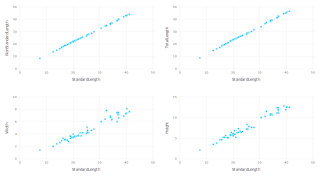

In [206]:
Gadfly.set_default_plot_size(32cm, 18cm)
fig1 = plot(perche, x=:StandardLength, y=:NonStandardLength, Geom.point)
fig2 = plot(perche, x=:StandardLength, y=:TotalLength, Geom.point)
fig3 = plot(perche, x=:StandardLength, y=:Width, Geom.point)
fig4 = plot(perche, x=:StandardLength, y=:Height, Geom.point)

gridstack([fig1 fig2; fig3 fig4])
# Oui on peut voir que la variable standardlength peut expliquer la variable non standardlength et Totallength 

## c) Sélection d'un sous-ensemble des variables explicatives 

Sélectionnez un sous-ensemble des variables explicatives pour lequel il n'y a pas de multicolinéarité.

Toutes les variables explicatives sont toutes liées linéairement entre elles. Pour éviter la multicolinéarité, il faut choisir une seule variable.

## c)  Identification du meilleur modèle de régression linéaire simple

Puisqu'il y a présence de multicolinéarité entre toutes les variables, on cherche le meilleur modèle unidimensionnel. Utilisez le critère de votre choix pour l'identifier.

**Suggestion :** Vous pouvez transformer la variable d'intérêt pour trouver le meilleur modèle linéaire unidimensionnel.

In [263]:
# presence de multicolinearites entre toutes les variables=> comparer les modeles unidimensionnelles
# utiliser coefficient de determination la plus eleve car ils sont tous unidimentionnelles
    
function computeR2(y,x)
    # build vector for y
    Y=Matrix(y[1:end,1:1])
    
    # build structure matrix
    X= hcat(ones(size(y,1)),Matrix(x[1:end,1:1]))
 
    # compute Beta=inverse(transpose(X)*X)*transpose(X)*Y
    B=inv(X'X)*(X'Y)

    yslope=X*B
    
    # SSR=sum from 1 to n (yslope-ymean)^2 where both y are dependent variable
    SSR=sum((yslope[i]-mean(Y))^2 for i=1:length(Y))
    
    # SST=sum from 1 to n (y-ymean)^2
    SST=sum((Y[i]-mean(Y))^2 for i=1:length(Y))
    
    # Ri^2=SSR/SST
    Ri2=SSR/SST 
    return Ri2
end

# trouver les coefficient de determination avec la variable d'interet Y transforme pour avoir des meilleurs resultats
R2=[]
for i=3:7
    Ri=computeR2(perche[1:end,2:2].^(1/3),perche[1:end,i:i])
    push!(R2,[names(perche[1:end,i:i])[1], Ri])
end
    
println(R2)

Any[Any["StandardLength", 0.9843452799099544], Any["NonStandardLength", 0.9845860710311374], Any["TotalLength", 0.9850824007482902], Any["Height", 0.9848359534655953], Any["Width", 0.9720039487487917]]


[-0.11006894814886707, 0.259229564024632]


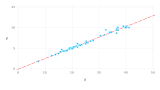

In [270]:
# StandardLength
# appliquant la transformation ^(1/3) les points s'approche plus de la droite 
# essai erreur pour trouver
x = Matrix(perche[1:end,3:3]) 
y = perche.Weight .^(1/3) 

n = length(y)

X = hcat(ones(n), x)

B= X \ y
println(B)
Gadfly.set_default_plot_size(16cm, 9cm)
plot(x=x, y=y, Geom.point, intercept = [B[1]], slope = [B[2]], Geom.abline(color="red", style=:dash))

[-619.1751143841218, 38.911467114564836]


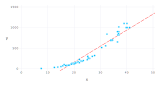

In [261]:
# StandardLength
# graph normal sans transformation
x = Matrix(perche[1:end,3:3]) 
y = perche.Weight 

n = length(y)

X = hcat(ones(n), x)

B= X \ y
println(B)
Gadfly.set_default_plot_size(16cm, 9cm)
plot(x=x, y=y, Geom.point, intercept = [B[1]], slope = [B[2]], Geom.abline(color="red", style=:dash))

## d) Vérification des hypothèses de la régression

Vérifiez si les hypothèses 1 à 4 de la régression sont satisfaites. Pour ce faire, tracer les graphiques suivants :
- le nuage des points {(ŷᵢ, eᵢ) : 1 ≤ i ≤ n} pour vérifier les hypothèses 1 et 2
- la droite de Henry pour vérifier l'hypothèse 4.

**Suggestion :** Vous pouvez utiliser la fonction `henryplot()` fournie pour tracer le diagramme quantile-quantile entre la loi normale et les résidus.


In [272]:
function henryplot(y::Vector{<:Real})

    n = length(y)
    ysorted = sort(y)

    p = ( collect(1:n) .- .5 ) /n

    fd = fit(Normal,y)

    q = quantile.(fd,p)

    plot(x=ysorted, y=q, Geom.point,
    Guide.xlabel("Empirical quantiles"), Guide.ylabel("Estimated quantiles"),
    Theme(discrete_highlight_color=c->nothing),
    Geom.abline(color="red"))

end

henryplot (generic function with 1 method)

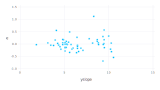

In [274]:
yslope = X*B
e = y - yslope

Gadfly.set_default_plot_size(16cm, 9cm)
plot(x=yslope, y=e, Geom.point, Guide.xlabel("yslope"), Guide.ylabel("e"))

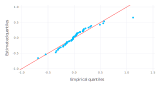

In [275]:
henryplot(e)

## e) Relation pour les poids originaux

Tracez le nuage de points illustrant les poids originaux des perches (dans le cas où vous auriez fait une transformation) en fonction votre variable explicative ainsi que la relation obtenue.

**Suggestion :** Utilisez la fonction `layer()` pour superposer plusieurs couches sur un graphique.

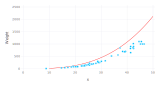

In [281]:
xx = collect(range(10, stop=50, length=1000))
yy = (B[1] .+ B[2]*xx).^3

obs = layer(perche, x=Matrix(perche[1:end,5:5]) , y=:Weight, Geom.point)
model = layer(x=xx, y=yy, Geom.line, Theme(default_color="red"))

Gadfly.set_default_plot_size(16cm, 9cm)
plot(obs, model)

# Exercice 4 : Recherche du meilleur modèle possible

Dans cet exercice, on cherche le meilleur modèle pour prédire le poids de perches. J'ai l'impression que les modèles suivants pourraient être pertinents :
- X = StandardLength * Width * Height (on suppose que le poisson est de la forme d'un prisme rectangulaire)
- X = StandardLength * Width^2 (on suppose que le poisson est un cylindre)
- etc.

C'est votre travail de créer de nouvelles variables explicatives à partir de celle que vous avez pour rechercher le meilleur modèle possible.

In [282]:
perche = filter(row -> row.Species == "Perche", data)

perche.Volume = perche.StandardLength .* perche.Width .* perche.Height

n = size(perche,1)

X = hcat(ones(n), perche.Volume)

β̂ = X\perche.Weight

ŷ = X*β̂

# l'erreur donc la vrai valeur de Weight- celle estime
e = perche.Weight - ŷ

SSE = e'e
SST = sum( (perche.Weight .- mean(perche.Weight)).^2 )

R² = 1 - SSE/SST

# on ne sait pas si c'est le meilleur modele mais on sait que c'est un bon modele car R2 a augmente

0.9859933724705562